# outline

1. Problem description and applications
1. Different difficulties
    - algebraic description
    - pyomo implementation
1. summary

In [ ]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 

## abstract model "linear packing"

### sets

- I set of boxes to be packed
- $Order:=\{(i,j) | i,j\in I,\; i<j\}$ used to define the packing order

### param

- $w_i$ width of box i
- $h_i$ heigth of box i

### vars

- $W$ total used width
- $x1_i$ left x-coordinate of box i
- $x2_i$ right x-coordinate of box i
- $y1_i$ left y-coordinate of box i
- $y2_i$ right 1-coordinate of box i

### constraints

- box width: left x coordinate and right x coordinate of box i differ by width of box i, i.e. $x2_i=x1_i+w_i$
- no box is placed after total used width, i.e. $x2_i \leq W$
- no overlap: either box i is placed before j or j before i, i.e. $x1_i \leq x1_j$ or $x1_j \leq x1_i$


### objective

- minimize total used width $W$

### model

$$
\begin{array}{lll}
\min & W & \\
s.t. & x_{i,2} \leq W & \forall i\\
     & x_{i,1},x_{i,2} \geq 0 & \forall i\\
     & y_{i,1} = 0 & \forall i\\
     & [x_{i,2}\leq x_{j,1}] \vee [x_{j,2} \leq x_{i,1}] & \forall i < j
\end{array}     
$$

In [ ]:
# helper functions

In [ ]:
## nb param
number_of_boxes = 5
shelf_depth = 1 # will be overwritten
np.random.seed(1111)

# data generation

def gen_box(number_of_boxes = number_of_boxes, wlow=1, whigh=100, hlow=1, hhigh=100):
    """generates random number_of_boxes data, where width of each box varies between wlow and whigh, and heigth within hlow and hheigth """
    return pd.DataFrame({
    'w': np.random.randint(wlow, whigh, size = number_of_boxes),
    'h': np.random.randint(hlow, hhigh, size = number_of_boxes),
    })


## data generation
boxes = gen_box()
data ={
    'data' : boxes,
    'solver' : 'cbc',
    'model_name': 'strip_packing',
    'shelf_depth' : 2 * boxes['h'].max()
}

shelf_depth = 2 * data['data']['h'].max()

In [ ]:
# inspect data
data['data'].head()

,w,h
0,29,15
1,56,9
2,82,13
3,13,87
4,35,9


In [ ]:
def _packing(df):
    """temp function to transform input data into a df like the solution for visualization"""
    dt = df.copy()
    dt['x1'] = dt['w'].cumsum() - dt['w']
    dt['x2'] = dt['w'].cumsum()
    dt['y1'] = 0
    dt['y2'] = dt['h']
    dt['r'] = 0
    return dt

def plot_solution(sol, shelf_depth = shelf_depth):
    """plot items bounding boxes"""
    
    fig, ax = plt.subplots()
    
    for i, x, y, w, h, r in zip(sol.index, sol['x1'], sol['y1'], sol['w'], sol['h'], sol['r']):
        color = 'g'
        # if box rotated then exchange heigth and width and use red as color
        if r:
            h, w = w, h
            color = 'r'
        ax.add_patch(Rectangle((x, y), w, h, 
                               edgecolor='k', facecolor=color, alpha=0.6))
        # place item name in the middle of each box
        ax.annotate(i, (x+w/2, y+h/2), color='w', weight='bold', fontsize=12, ha='center', va='center')
    
    # set axis limits
    ax.set_xlim(0, 1.1*sol["w"].sum())
    ax.set_ylim(0, shelf_depth*1.1)
    
    # draw line for total used width
    ax.axvline(sol["x2"].max(), ymin = 0, ymax = shelf_depth/ax.get_ylim()[1],
               label="shelf width $W$", color="r")
    ax.fill_between([0, ax.get_xlim()[1]], [shelf_depth, shelf_depth], color="c", alpha=0.2)
    ax.set_title('packing')
    ax.set_xlabel("width")
    ax.set_ylabel("heigth")
    

CPU times: user 50.9 ms, sys: 12.6 ms, total: 63.5 ms
Wall time: 79.8 ms


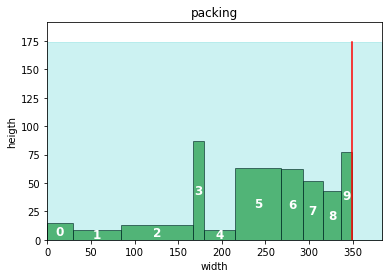

In [ ]:
%%time
# visualizse fifo packing with no rotation
sol = _packing(data['data'])
plot_solution(sol, shelf_depth = shelf_depth)

In [ ]:
# pyomo implementation

def SP_simple(data):
    """simple strip packing, but useful to study good/new neighboor constraints later"""
    
    # simple upper bound
    w_bound = data['data']['w'].sum()
    
    # instanciate model
    m = pyo.ConcreteModel(data['model_name'])
    # sets
    m.I = pyo.Set(initialize = data['data'].index, doc = 'items')
    m.Order = pyo.Set(initialize = m.I * m.I, filter = lambda m,i,j: i<j)
    
    # vars
    m.x1 = pyo.Var(m.I, domain = pyo.NonNegativeReals, bounds = (0,w_bound))
    m.x2 = pyo.Var(m.I, domain = pyo.NonNegativeReals, bounds = (0,w_bound))
    m.W = pyo.Var(domain = pyo.NonNegativeReals, doc = 'total width, to be optimized')
    m.r = pyo.Var(domain = pyo.Boolean, initialize = False, doc = 'not used in no rotation model')
    
    # objective
    m.OBJ = pyo.Objective(expr = m.W, sense = pyo.minimize)
    
    # param
    @m.Param(m.I)
    def w(m,i):
        return data['data'].filter(items = [i], axis = 0)['w'].values[0]
    
    # constraints
    @m.Constraint(m.I, doc = 'determines box i size')
    def bounding_box(m,i):
        return m.x2[i] == m.x1[i] + m.w[i]
    
    @m.Constraint(m.I, doc = 'defines total width, to be optimized')
    def total_width(m,i):
        return m.x2[i] <= m.W
    
    @m.Disjunction(m.Order, xor=True)
    def no_overlap(m, i, j):
        return [m.x2[i] <= m.x1[j],
                m.x2[j] <= m.x1[i]]
       
    
    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    
    # choose solver and apply solver
    solver = pyo.SolverFactory(data['solver'])
    solver.solve(m)
    
    # extract solution
    sol = data['data'].copy()
    # extract coords from solution
    sol['x1'] = [pyo.value(m.x1[i]) for i in m.I]
    sol['x2'] = [pyo.value(m.x2[i]) for i in m.I]
    # placeholder
    sol['y1'] = [0 for i in m.I]
    sol['y2'] = sol['h']
    sol['r'] = [False for i in m.I]
        
    return sol

CPU times: user 1.66 s, sys: 488 ms, total: 2.15 s
Wall time: 39min 5s


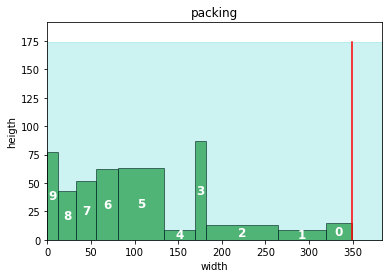

In [ ]:
%%time
sol = SP_simple(data)
# visualise sollution
plot_solution(sol)

## Add rotation to model

Obviously rotating certain boxes would result in a tighter packing. Therefore we add a boolean variable `r_i` which equals true iff the box was rotated.

$$
\begin{array}{lll}
\min & W & \\
s.t. & x_{i,2} \leq W & \forall i\\
     & x_{i,1},x_{i,2} \geq 0 & \forall i\\
     & y_{i,1} = 0 & \forall i\\
     & [x_{i,2}\leq x_{j,1}] \vee [x_{j,2} \leq x_{i,1}] & \forall i < j\\
     & \left[ \begin{array}{ll}
     r_i= & false\\
     x_{i,2} = & x_{i,1} + w_i\\
     y_{i,2} = & y_{i,1} + h_i
     \end{array} \right] \vee 
     \left[ \begin{array}{ll}
     r_i= & true\\
     x_{i,2} = & x_{i,1} + h_i\\
     y_{i,2} = & y_{i,1} + w_i
     \end{array}\right] & \forall i < j
\end{array}     
$$


In [ ]:
def SP_rot(data):
    """strip packing with rotation"""
    
    W_ub = data['data']['w'].sum()
    
    m = pyo.ConcreteModel()
    
    # sets
    m.I = pyo.Set(initialize = data['data'].index, doc = 'plants')
    m.Order = pyo.Set(initialize = m.I * m.I, filter = lambda m,i,j:i<j, doc ='ordering of plants')
    
    # vars
    m.W = pyo.Var(bounds = (0,W_ub), doc = 'total optimal width')
    m.x1 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'LHS of item i on x axis')
    m.x2 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'RHS of item i on x axis')
    m.y1 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'LHS of item i on y axis')
    m.y2 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'RHS of item i on y axis')
    m.r = pyo.Var(m.I, domain = pyo.Boolean)
    
    # objective
    @m.Objective()
    def minimal_width(m):
        return m.W
    
    # param
    @m.Param(m.I)
    def w(m,i):
        return data['data'].filter(items = [i], axis = 0)['w'].values[0]
    @m.Param(m.I)
    def h(m,i):
        return data['data'].filter(items = [i], axis = 0)['h'].values[0]
    
    # constraints
    @m.Constraint(m.I)
    def c1(m,i):
        return m.x2[i] <= m.W
    @m.Constraint(m.I)
    def y1_loc(m,i):
        return m.y1[i] == 0
    @m.Disjunction(m.I)
    def rotation(m,i):
        return [
            [m.r[i] == False, 
             m.x2[i] == m.x1[i] + m.w[i],
             m.y2[i] == m.y1[i] + m.h[i]
            ],
            [m.r[i] == True,
             m.x2[i] == m.x1[i] + m.h[i],
             m.y2[i] == m.y1[i] + m.w[i]
            ]
        ]
    @m.Disjunction(m.Order)
    def no_overlap(m,i,j):
        return [
            [m.x2[i] <= m.x1[j]],
            [m.x2[j] <= m.x1[i]]
        ]
    
    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    
    # choose solver and apply solver
    solver = pyo.SolverFactory(data['solver'])
    solver.solve(m)
    
    # extract solution
    sol = data['data'].copy()
    # extract coords from solution
    sol['x1'] = [pyo.value(m.x1[i]) for i in m.I]
    sol['x2'] = [pyo.value(m.x2[i]) for i in m.I]
    # placeholder
    sol['y1'] = [pyo.value(m.y1[i]) for i in m.I]
    sol['y2'] = [pyo.value(m.y2[i]) for i in m.I]
    sol['r'] = [pyo.value(m.r[i]) for i in m.I]
    
    return sol

CPU times: user 4.74 s, sys: 2.93 s, total: 7.67 s
Wall time: 2h 43min 43s


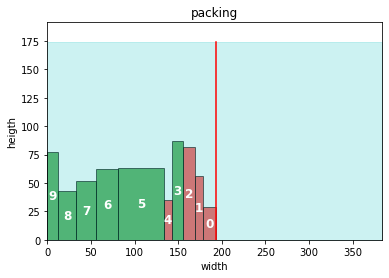

In [ ]:
%%time
sol_rot = SP_rot(data)
plot_solution(sol_rot)

## Add packing in 2 dimensions

Again obviously we can reduce the required total width if we allow to pack boxes in 2 dimensions, e.g. we place a box behind another.

### Additional constraints

- upper $y$ coordinate of box does not exceed shelf depth $D$
- no overlap of boxes in y-axis

### Model

$$
\begin{array}{lll}
\min & W & \\
s.t. & x_{i,2} \leq W & \forall i\\
     & y_{i,2} \leq D & \forall i\\
     & x_{i,1},x_{i,2}, y_{i,1}, y_{i,2} \geq 0 & \forall i\\
     & y_{i,1} = 0 & \forall i\\
     & [x_{i,2}\leq x_{j,1}] \vee 
       [x_{j,2} \leq x_{i,1}] \vee       
       [y_{i,2}\leq y_{j,1}] \vee 
       [y_{j,2} \leq y_{i,1}]
       & \forall i < j\\
     & \left[ \begin{array}{ll}
     r_i= & false\\
     x_{i,2} = & x_{i,1} + w_i\\
     y_{i,2} = & y_{i,1} + h_i
     \end{array} \right] \vee 
     \left[ \begin{array}{ll}
     r_i= & true\\
     x_{i,2} = & x_{i,1} + h_i\\
     y_{i,2} = & y_{i,1} + w_i
     \end{array}\right] & \forall i < j
\end{array}     
$$

In [ ]:
data


{'data':     w   h
 0  29  15
 1  56   9
 2  82  13
 3  13  87
 4  35   9
 5  53  63
 6  25  62
 7  23  52
 8  21  43
 9  12  77,
 'solver': 'cbc',
 'model_name': 'strip_packing',
 'shelf_depth': 174}

In [ ]:
def SP_2dim_rot(data):
    """strip packing with rotation in 2 dimension"""
    
    W_ub = data['data']['w'].sum()
    
    m = pyo.ConcreteModel()
    
    # sets
    m.I = pyo.Set(initialize = data['data'].index, doc = 'plants')
    m.Order = pyo.Set(initialize = m.I * m.I, filter = lambda m,i,j:i<j, doc ='ordering of plants')
    
    # vars
    m.W = pyo.Var(bounds = (0,W_ub), doc = 'total optimal width')
    m.x1 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'LHS of item i on x axis')
    m.x2 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'RHS of item i on x axis')
    m.y1 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'LHS of item i on y axis')
    m.y2 = pyo.Var(m.I, bounds = (0,W_ub), doc = 'RHS of item i on y axis')
    m.r = pyo.Var(m.I, domain = pyo.Boolean)
    
    # objective
    @m.Objective()
    def minimal_width(m):
        return m.W
    
    # param
    @m.Param(m.I)
    def w(m,i):
        return data['data'].filter(items = [i], axis = 0)['w'].values[0]
    @m.Param(m.I)
    def h(m,i):
        return data['data'].filter(items = [i], axis = 0)['h'].values[0]
    m.shelf_depth = pyo.Param(mutable = True,
                              initialize = data['shelf_depth'])
    
    # constraints
    @m.Constraint(m.I)
    def minimize_width(m,i):
        return m.x2[i] <= m.W
    @m.Constraint(m.I)
    def max_heigth(m,i):
        return m.y2[i] <= m.shelf_depth
    
    @m.Disjunction(m.I)
    def rotation(m,i):
        return [
            [m.r[i] == False, 
             m.x2[i] == m.x1[i] + m.w[i],
             m.y2[i] == m.y1[i] + m.h[i]
            ],
            [m.r[i] == True,
             m.x2[i] == m.x1[i] + m.h[i],
             m.y2[i] == m.y1[i] + m.w[i]
            ]
        ]
    @m.Disjunction(m.Order)
    def no_overlap(m,i,j):
        return [
            [m.x2[i] <= m.x1[j]],
            [m.x2[j] <= m.x1[i]],
            [m.y2[i] <= m.y1[j]],
            [m.y2[j] <= m.y1[i]]
        ]
    
    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    
    # choose solver and apply solver
    solver = pyo.SolverFactory(data['solver'])
    solver.solve(m)
    
    # extract solution
    sol = data['data'].copy()
    # extract coords from solution
    sol['x1'] = [pyo.value(m.x1[i]) for i in m.I]
    sol['x2'] = [pyo.value(m.x2[i]) for i in m.I]
    # placeholder
    sol['y1'] = [pyo.value(m.y1[i]) for i in m.I]
    sol['y2'] = [pyo.value(m.y2[i]) for i in m.I]
    sol['r'] = [pyo.value(m.r[i]) for i in m.I]
    
    return sol

CPU times: user 3.23 s, sys: 1.36 s, total: 4.59 s
Wall time: 2h 59min 8s


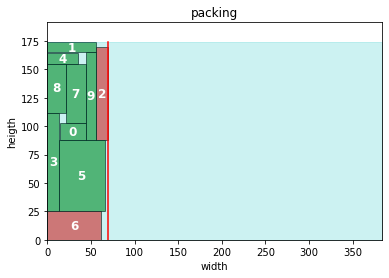

In [ ]:
%%time
sol_rot = SP_2dim_rot(data)
plot_solution(sol_rot)